# Applied Data Analysis: CMU Movie Summary Corpus

## Dataset Details
This dataset contains metadata and plot summaries for over 42,000 movies. The dataset is a rich resource for exploring relationships between movies, characters, and plot content.

- **Name**: CMU Movie Summary Corpus
- **Source**: [CMU Movie Summary Corpus Dataset](https://www.cs.cmu.edu/~ark/personas/)
- **Size**: 46 MB (compressed)
- **Typology**: Text + Graphs + Numerical Data
- **Tags**: Movies, Characters, Plot Summaries, Metadata

The dataset contains:
- **Movie Metadata**: Information about the movies such as titles, genres, release dates.
- **Character Metadata**: Details about the characters in each movie.
- **Plot Summaries**: Textual summaries of movie plots extracted from Wikipedia.

You can read more about the dataset in the paper: [Bamman et al., 2013](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf).

## Part 1 : Understanding the data
In this section, we will begin by loading the dataset and performing some initial exploratory data analysis (EDA). This will help us understand the structure and content of the data, identify any missing values, and get a sense of the distributions and relationships between different variables.

In [237]:
# Imports
import importlib
from collections import Counter
import src.data.CMU_dataset_dataloader as CMU_dataset_dataloader
import src.utils.data_utils as data_utils
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

importlib.reload(CMU_dataset_dataloader)
importlib.reload(data_utils)

# Constants
CMU_DATA_DOWNLOAD_PATH = 'https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
CMU_DATA_PATH_INITIAL = 'data/initial/'

In [2]:
# Load the plot summaries
print("Plot Summaries:")
plots = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'plot_summaries.txt', categories=['movie_id', 'summary'])
df_plots = plots.data

df_plots.sample(5)

Plot Summaries:


,movie_id,summary
20428,5929445,"In the swamps of Louisiana, Dr. Alec Holland w..."
39464,5458357,The films follows a series of encounters of a ...
39565,19991665,The isolated Kelley family struggle with their...
18571,14278837,"As the Griffin family is watching television, ..."
38379,3017464,"In 1956 Schenectady, New York, waitress Shirle..."


In [3]:
# Load the movie metadata
print("\nMovie Metadata:")
categories = [
    'wikipedia_movie_id',
    'freebase_movie_id',
    'movie_name',
    'release_date',
    'box_office_revenue',
    'runtime',
    'languages',
    'countries',
    'genres'
    ]
movies = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'movie.metadata.tsv', categories=categories)
df_movies = movies.data

df_movies.sample(5)


Movie Metadata:


,wikipedia_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
57259,14559231,/m/03d7xg0,Brewster's Millions,1914-04-15,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi..."
8760,25894953,/m/0b6gst9,Tora-san's Promise,1981-12-28,NaN,101.0,{},"{""/m/03_3d"": ""Japan""}","{""/m/0gw5n2f"": ""Japanese Movies""}"
60425,9390971,/m/0286_88,Lucifer Rising,1980,NaN,30.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/0424mc"": ""Expe..."
68346,7809854,/m/026dtc0,The Legend of the North Wind,1992,NaN,70.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/06mkj"": ""Spain""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
41106,14680001,/m/03gsx1p,Ultraman Cosmos 2: The Blue Planet,NaN,NaN,75.0,{},"{""/m/03_3d"": ""Japan""}","{""/m/0gw5n2f"": ""Japanese Movies""}"


In [238]:
# Load the character metadata
print("\nCharacter Metadata:")
categories = [
    'wikipedia_movie_id', 
    'freebase_movie_id', 
    'release_date', 
    'character_name', 
    'actor_birth', 
    'actor_gender', 
    'actor_height', 
    'actor_ethnicity', 
    'actor_name', 
    'actor_age', 
    'freebase_character_actor_id', 
    'freebase_character_id', 
    'freebase_actor_id'
    ]
characters = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'character.metadata.tsv', categories=categories)
df_characters = characters.data
df_characters.sample(5)


Character Metadata:


,wikipedia_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_id,freebase_character_id,freebase_actor_id
76428,3291150,/m/093p45,2005-11-25,NaN,1943-08-04,M,NaN,NaN,Michael J. McCulley,62.0,/m/0bdtpg2,NaN,/m/02xmwn
263755,1470104,/m/05411x,1917-09-21,Millicent Dunston,1901-07-14,F,NaN,NaN,Virginia Lee,16.0,/m/0j6x47b,/m/0j6x47f,/m/0j6x47n
219962,19027024,/m/04j9_gt,1983-11-04,Ramesh's Mother,1931-01-04,F,1.60,/m/0dryh9k,Nirupa Roy,52.0,/m/0cg9k71,/m/0h7039h,/m/04328m
163546,24328926,/m/07sbsz6,1989-04-14,NaN,1959-04-02,M,NaN,NaN,Steve Monarque,30.0,/m/0bhg0hz,NaN,/m/0bl1p7
39291,23615900,/m/080b54x,2010-09-03,Caitlyn Geller,1993-08-11,F,1.57,NaN,Alyson Stoner,17.0,/m/0h4yw42,/m/0h5vd14,/m/02bwjv


As we can see directly here, lot of that is invalid or inexistant. The only way to go : preprocessing.

### Plot summaries preprocessing

count    42303.000000
mean      1784.034300
std       1808.925641
min         99.000000
25%        508.000000
50%       1079.000000
75%       2604.500000
max      28159.000000
Name: summary_length, dtype: float64


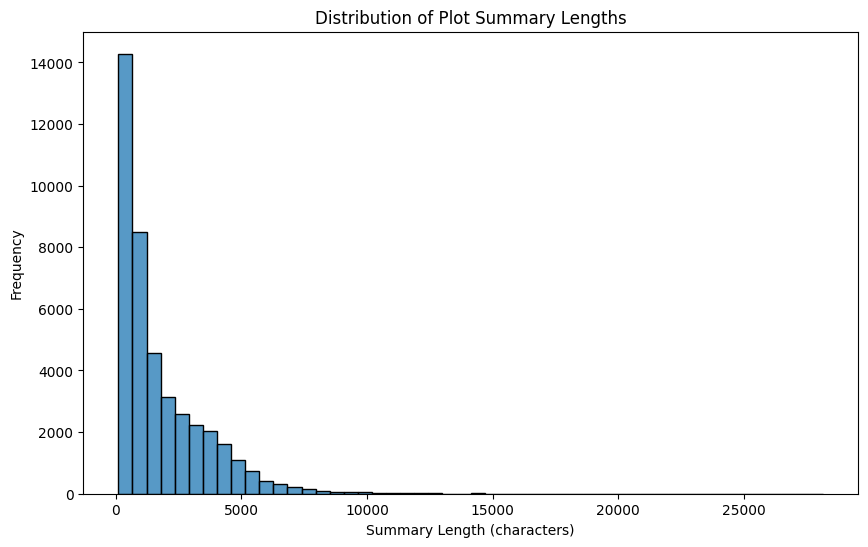

,movie_id,summary,summary_length
8562,29836849,"A park ranger must lead a US senator, a disgra...",260
17436,23449348,A inmate named Salem escapes from an insane a...,450
21623,15216510,The Age of Success is a melodrama about lust f...,130
6055,6030966,Rama Krishna or Rakhi aspires to become railw...,809
25916,10064188,"Valentina Suarez , a young and ambitious recen...",943


In [5]:
# Plot summaries pre-processing

# missing values
assert df_plots['summary'].isnull().sum() == 0
assert df_plots['movie_id'].isnull().sum() == 0

# Average plot summary length
df_plots['summary_length'] = df_plots['summary'].apply(len)
print(df_plots['summary_length'].describe())

# # ==> very heterogeneous lengths 

# # Plotting summary lengths distribution
plt.figure(figsize=(10,6))
sns.histplot(df_plots['summary_length'], bins=50)
plt.title('Distribution of Plot Summary Lengths')
plt.xlabel('Summary Length (characters)')
plt.ylabel('Frequency')
plt.show()

# # Print the preprocessed summaries
df_plots.sample(5)

### Movie metadata preprocessing

C:\Users\vaffs\AppData\Local\Temp\ipykernel_15864\926487634.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['release_date'] = pd.to_datetime(df_movies['release_date'], errors='coerce')
C:\Users\vaffs\AppData\Local\Temp\ipykernel_15864\926487634.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['languages'] = df_movies['languages'].apply(data_utils.convert_to_dict)
C:\Users\vaffs\AppData\Local\Temp\ipykernel_15864\926487634.py:22: SettingWithCopyWarning: 
A value is trying to be s

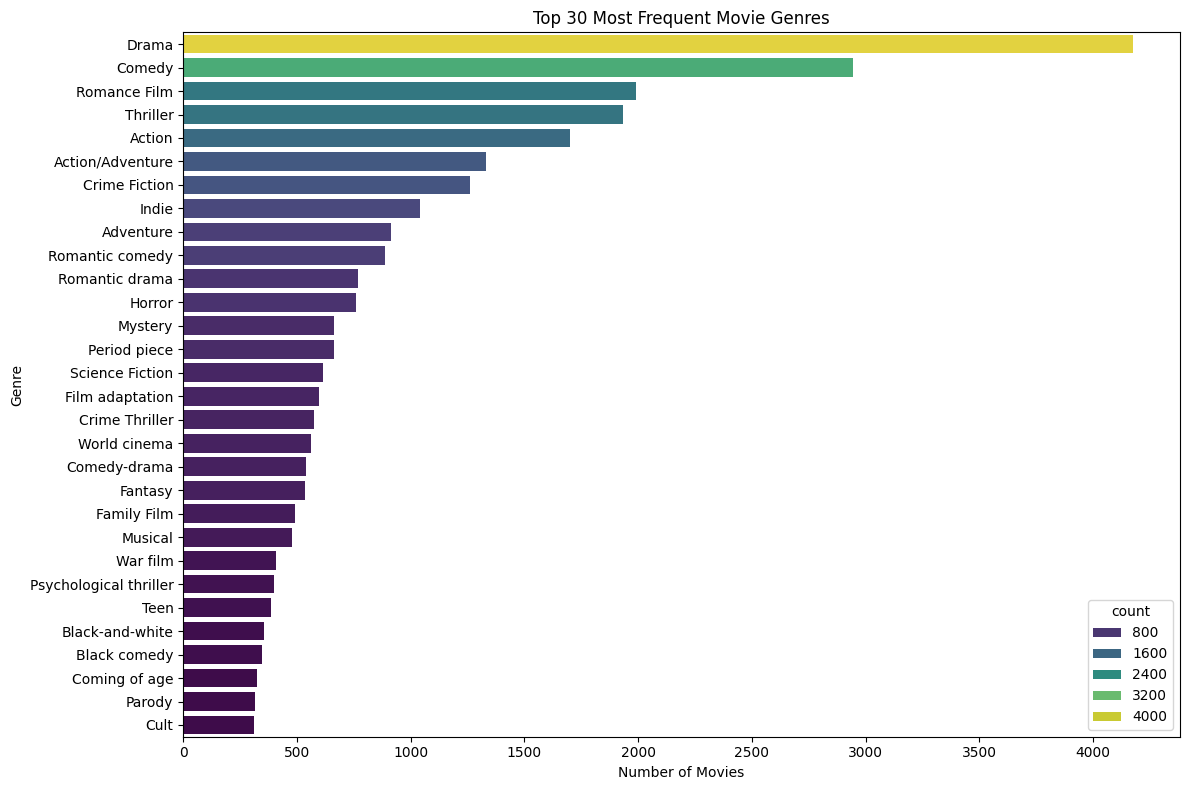

In [6]:
# Removing freebase (deprecated)
if 'freebase_movie_id' in df_movies.columns:
    df_movies.drop(columns=['freebase_movie_id'], inplace=True)

# missing values
df_movies = df_movies.dropna()

assert df_movies['wikipedia_movie_id'].isnull().sum() == 0
assert df_movies['movie_name'].isnull().sum() == 0
assert df_movies['release_date'].isnull().sum() == 0
assert df_movies['box_office_revenue'].isnull().sum() == 0
assert df_movies['runtime'].isnull().sum() == 0
assert df_movies['languages'].isnull().sum() == 0
assert df_movies['countries'].isnull().sum() == 0
assert df_movies['genres'].isnull().sum() == 0

# Format release date
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'], errors='coerce')

# Extracting the language values for all rows
df_movies['languages'] = df_movies['languages'].apply(data_utils.convert_to_dict)
df_movies['countries'] = df_movies['countries'].apply(data_utils.convert_to_dict)
df_movies['genres'] = df_movies['genres'].apply(data_utils.convert_to_dict)

all_genres = df_movies['genres'].apply(lambda x: list(x.values()) if isinstance(x, dict) else []).explode()
genre_counts = Counter(all_genres)

genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['genre', 'count']).sort_values(by='count', ascending=False)

top_genres = genre_counts_df.head(30)

# Plotting the top genres using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=top_genres, y='genre', x='count', hue='count', palette="viridis")
plt.title('Top 30 Most Frequent Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

### Character metadata preprocessing

In [239]:
# Removing freebase (deprecated)
if 'freebase_movie_id' in df_characters.columns:
    df_characters.drop(columns=['freebase_movie_id'], inplace=True)
if 'freebase_character_actor_id' in df_characters.columns:
    df_characters.drop(columns=['freebase_character_actor_id'], inplace=True)
if 'freebase_character_id' in df_characters.columns:
    df_characters.drop(columns=['freebase_character_id'], inplace=True)
if 'freebase_actor_id' in df_characters.columns:
    df_characters.drop(columns=['freebase_actor_id'], inplace=True)

# missing values
#df_characters = df_characters.dropna()

# Format release date
df_characters['release_date'] = pd.to_datetime(df_characters['release_date'], errors='coerce')
df_characters['actor_birth'] = pd.to_datetime(df_characters['actor_birth'], errors='coerce')

df_characters.sample(5)

,wikipedia_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age
83801,14738699,NaT,NaN,1902-10-05 00:00:00,M,1.6256,NaN,Larry Fine,NaN
380954,9269440,1943-10-07,NaN,1920-05-13 00:00:00,F,NaN,NaN,Judith Sulian,23.0
404598,10185281,1953-05-08,NaN,1904-07-11 00:00:00,M,NaN,NaN,Philip Leaver,48.0
42202,15996858,1936-01-01,NaN,1886-02-10 00:00:00,M,1.8600,NaN,Olin Howland,NaN
334671,31969018,2011-10-27,NaN,NaN,M,NaN,NaN,Avinash Chand Wadkar,NaN


## Part 2 : Exploratory Data Analysis to answer basic per-fearture's questions

This part aims to investigate how each feature that we find as being individually important is impacting the box office revenue. For that, we will answer the following questions :
- What is the average box office revenue by release season (e.g., summer, winter holiday, other)?
- Which 20 genres have the highest average box office revenue?
- How does film runtime correlate with box office revenue, and do longer or shorter films tend to perform better?
- Which 20 languages have the highest average box office revenue?

### What is the average box office revenue by release season (e.g., summer, winter holiday, other)?
- Display average box office revenue by release season (summer, winter holiday, other).

Average Box Office Revenue by Release Season:
release_season
Holiday    5.219552e+07
Other      5.062053e+07
Summer     7.624119e+07
Name: mean, dtype: float64


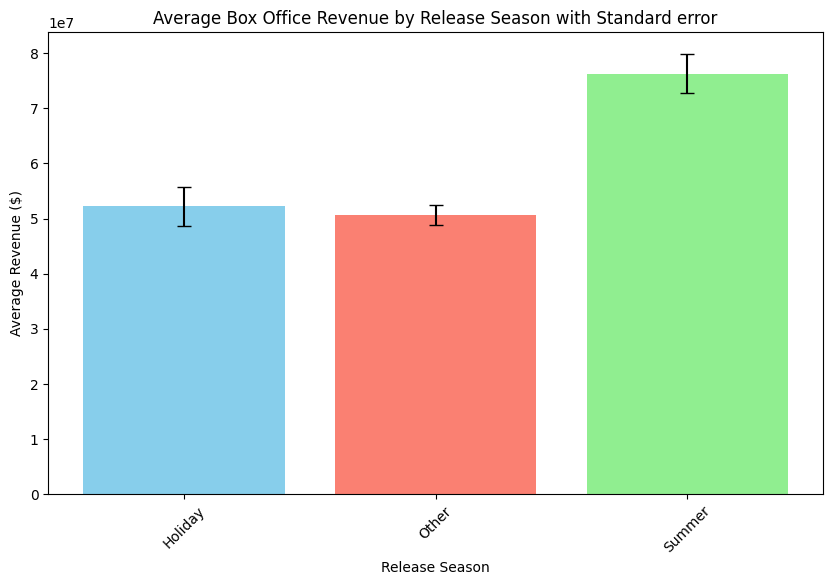

In [8]:
# Apply the function to create a 'release_season' column
df_movies['release_season'] = df_movies['release_date'].apply(data_utils.categorize_release_season)

# Calculate average revenues and standard error for each season
season_stats = df_movies.groupby('release_season')['box_office_revenue'].agg(['mean', 'sem'])

# Print the average revenues by season
print("Average Box Office Revenue by Release Season:")
print(season_stats['mean'])

# Plot the average revenues with standard error bars
plt.figure(figsize=(10, 6))
plt.bar(season_stats.index, season_stats['mean'], yerr=season_stats['sem'], color=['skyblue', 'salmon', 'lightgreen'], capsize=5)
plt.title('Average Box Office Revenue by Release Season with Standard error')
plt.xlabel('Release Season')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()


## !!!The other is almost the same as holidays. Redo analysis!!!

### Analysis of Average Box Office Revenue by Release Season

The results indicate the following average revenues:

- **Holiday**: $52.20 million
- **Summer**: $76.24 million
- **Other**: $50.62 million

#### Observations !!!Redo!!!

1. **Higher Revenue in Summer and Holiday Seasons**: Movies released during the summer and holiday seasons tend to generate nearly double the revenue of films released during other times. This trend suggests that these peak periods are associated with higher box office performance.

2. **Lower Revenue for Other Seasons**: Films released outside the summer and holiday months have an average revenue of about $39.62 million, noticeably lower than those released during peak seasons.

#### Possible Causes

1. **Increased Audience Availability**: During the summer and holiday breaks, more people are available for leisure activities, making them more likely to attend movies. This larger audience availability can significantly boost box office revenue.

2. **Strategic Releases**: Studios often schedule their major, high-budget, or highly anticipated films for these peak seasons to capture larger audiences. Action-packed blockbusters and family-friendly films are commonly released during these times, appealing to a broad audience.

3. **Marketing Efforts**: Studios usually invest heavily in marketing campaigns leading up to summer and holiday releases, which builds awareness and anticipation. This increased promotion can lead to higher attendance.

4. **Genre Preferences**: Movies released during summer and holiday seasons are often action films, family-friendly titles, or major franchise installments, which traditionally perform well at the box office. This genre trend could contribute to the higher average revenues during these seasons.

5. **Competitive Advantage**: Although peak seasons bring more competition, the expanded audience size during these times may offset the risk, making summer and holiday releases more profitable for studios.


### Which 20 genres have the highest average box office revenue?
- Display highest 20 average box office revenue by genre.

In [9]:
# Convert the 'genres' dictionary to a list of genre names for each movie
df_movies['all_genres'] = df_movies['genres'].apply(lambda x: list(x.values()) if isinstance(x, dict) else [])

# Explode the 'all_genres' list so that each genre has its own row
df_genres = df_movies.explode('all_genres')

# Count movies by genre
genre_counts = df_genres['all_genres'].value_counts()
print("Number of Movies by Genre:")
print(genre_counts)

Number of Movies by Genre:
all_genres
Drama                       3371
Comedy                      2474
Thriller                    1698
Romance Film                1640
Action                      1425
                            ... 
Live action                    1
Archaeology                    1
Libraries and librarians       1
Clay animation                 1
Goat gland                     1
Name: count, Length: 298, dtype: int64


Average Box Office Revenue by Top 20 Genres:
                                mean           sem  count
all_genres                                               
Computer Animation      3.171591e+08  7.677825e+07     38
Superhero               2.178622e+08  3.762794e+07     46
Fantasy Adventure       2.054833e+08  4.307759e+07     49
Superhero movie         1.859170e+08  2.239684e+07     96
Adventure Comedy        1.595969e+08  3.485537e+07     52
Disaster                1.512076e+08  3.548944e+07     73
Tragedy                 1.482234e+08  5.135599e+07     45
Doomsday film           1.479428e+08  2.524307e+07     62
Fantasy                 1.359706e+08  1.092177e+07    486
Epic                    1.314819e+08  4.008825e+07     82
Animation               1.258715e+08  1.528788e+07    137
Action Thrillers        1.207702e+08  1.173864e+07    158
Adventure               1.203559e+08  7.781649e+06    788
Science Fiction         1.186756e+08  9.385315e+06    552
Airplanes and airports  1.1

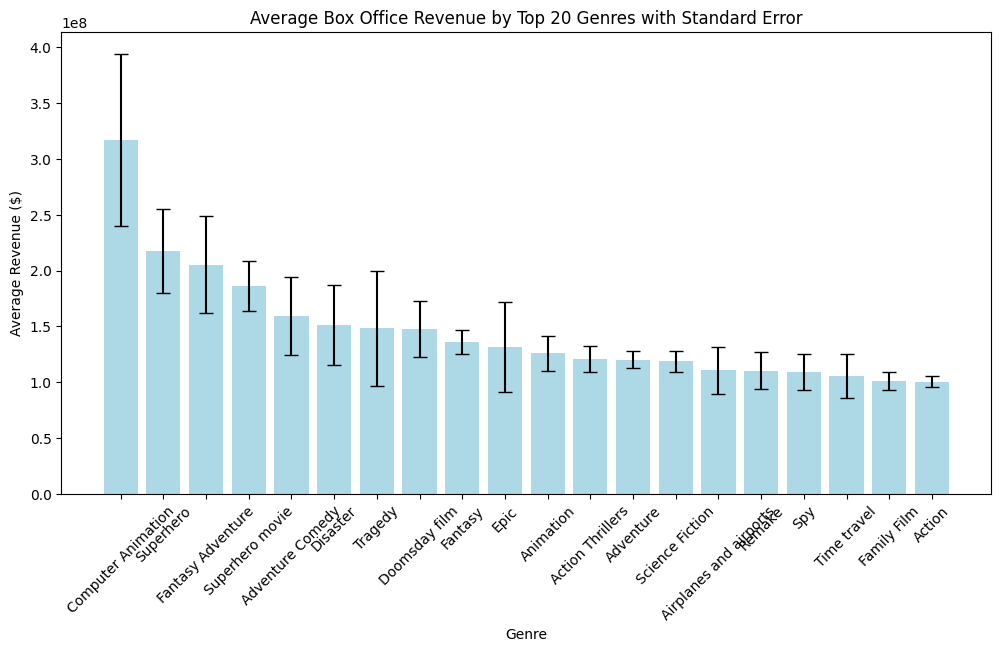

In [10]:
# Calculate average revenue, standard error and count by primary genre 
genre_stats = df_genres.groupby('all_genres')['box_office_revenue'].agg(['mean', 'sem', 'count'])

#We filter out those that are not statistically relevant
genre_stats = genre_stats[genre_stats['count'] >= 30] 

# Select the top 20 genres with the highest average revenue
top_20_genres = genre_stats.sort_values(by='mean', ascending=False).head(20)

# Print the average revenue by genre
print("Average Box Office Revenue by Top 20 Genres:")
print(top_20_genres)

# Plot the average revenue by genre
plt.figure(figsize=(12, 6))
plt.bar(top_20_genres.index, top_20_genres['mean'], yerr=top_20_genres['sem'], color='lightblue', capsize=5)
plt.title('Average Box Office Revenue by Top 20 Genres with Standard Error')
plt.xlabel('Genre')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

# !!!Redo the analysis!!!

### Analysis of Average Box Office Revenue by Genre

The results indicate the following top average revenues by genre:

- **Disaster**: $494.47 million
- **Space Opera**: $423.15 million
- **Costume Adventure**: $333.11 million
- **Space Western**: $266.47 million
- **Vampire Movies**: $247.45 million

#### Observations

1. **High Revenue for Genre-Specific Blockbusters**: Disaster, space opera, and costume adventure films show the highest average revenues, all above $300 million. These genres often involve high budgets and large-scale productions, appealing to broad audiences through spectacular visuals and thrilling storylines.

2. **Fantasy and Adventure Appeal**: Many genres in the top 20, such as fantasy adventure, sword and sorcery, and swashbuckler films, fall under the fantasy and adventure categories. These genres tend to attract diverse audiences, from families to adult viewers, likely contributing to their high average box office performance.

3. **Performance of Supernatural Themes**: Genres like vampire movies and fantasy comedy also perform well, suggesting that supernatural and otherworldly themes resonate strongly with audiences. These themes often lend themselves to franchise building and sequels, which can enhance their overall box office returns.

4. **Broad Appeal of Superhero and Inspirational Dramas**: Genres like superhero movies and inspirational dramas also feature among the high-revenue genres. The strong following for superhero films and the emotional appeal of inspirational stories can draw substantial audiences, especially when paired with well-known actors and directors.

5. **Lower Revenue for Less-Common Genres**: Although still in the top 20, genres like wuxia and mystery show comparatively lower revenues, with averages below $100 million. These genres may have dedicated fan bases but often lack the widespread appeal of high-budget blockbusters.

#### Possible Causes

1. **Audience Preference for High-Production Genres**: Genres with high production values, such as disaster and space opera films, generally have larger budgets that allow for impressive visual effects, drawing audiences seeking thrilling cinematic experiences.

2. **Franchise and Sequel Potential**: Genres with established franchise potential, like space opera and superhero movies, consistently perform well. The brand recognition and continuity associated with these genres can drive repeat viewership and loyalty.

3. **Marketing and Distribution**: Big-budget films in genres like disaster, fantasy, and space opera typically receive extensive marketing support, leading to higher visibility. Wide global distribution further enhances their reach and contributes to their high box office revenue.

4. **Genre-Specific Appeal**: Certain genres, such as inspirational drama and holiday films, may appeal to niche audiences but still generate high revenue due to their focused, emotional storytelling. These genres may resonate particularly well with audiences seeking uplifting or seasonal content.

5. **Cross-Demographic Appeal**: Genres like costume adventure and fantasy often appeal to various demographic groups, from families to younger audiences. This broad appeal can contribute to stronger box office performance, as these genres are accessible to diverse age groups.

### How does film runtime correlate with box office revenue, and do longer or shorter films tend to perform better?
- Analyze revenue by runtime to see if longer or shorter films tend to perform better.


Average Box Office Revenue by Runtime Category:
runtime_category
Short     3.880062e+07
Medium    4.462968e+07
Long      8.806463e+07
Name: mean, dtype: float64

Runtime definitions based on quantiles:
- Short: ≤ 96.0 minutes
- Medium: 97.0-110.0 minutes
- Long: > 111.0 minutes


C:\Users\vaffs\AppData\Local\Temp\ipykernel_15864\3062874646.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_stats = df_movies.groupby('runtime_category')['box_office_revenue'].agg(['mean', 'sem'])


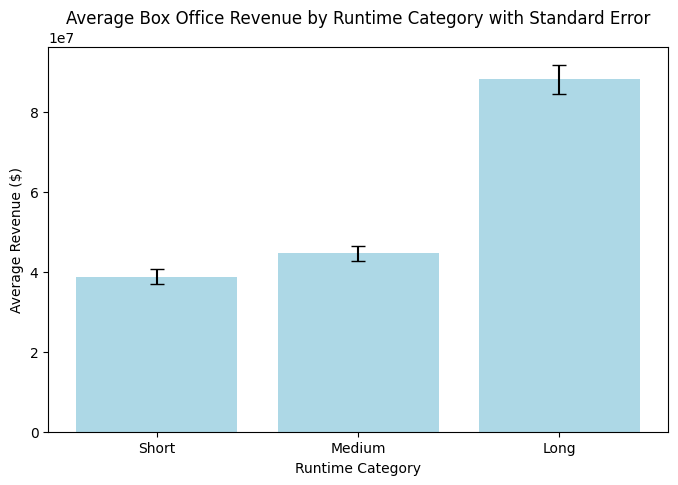

In [11]:
# Define runtime bins based on quantiles for equal-sized groups
df_movies['runtime_category'] = pd.qcut(df_movies['runtime'], q=3, labels=["Short", "Medium", "Long"])

# Verify the approximate runtime boundaries for each category
short_max = df_movies[df_movies['runtime_category'] == "Short"]['runtime'].max()
medium_min = df_movies[df_movies['runtime_category'] == "Medium"]['runtime'].min()
medium_max = df_movies[df_movies['runtime_category'] == "Medium"]['runtime'].max()
long_min = df_movies[df_movies['runtime_category'] == "Long"]['runtime'].min()

# Calculate average revenue and sem by runtime category
runtime_stats = df_movies.groupby('runtime_category')['box_office_revenue'].agg(['mean', 'sem'])

# Print the average revenue by runtime category
print("Average Box Office Revenue by Runtime Category:")
print(runtime_stats['mean'])
print(f"\nRuntime definitions based on quantiles:\n- Short: ≤ {short_max} minutes\n- Medium: {medium_min}-{medium_max} minutes\n- Long: > {long_min} minutes")

# Plot the average revenue by runtime category
plt.figure(figsize=(8, 5))
plt.bar(runtime_stats.index, runtime_stats['mean'], yerr=runtime_stats['sem'], color='lightblue', capsize=5)
plt.title('Average Box Office Revenue by Runtime Category with Standard Error')
plt.xlabel('Runtime Category')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=0)
plt.show()

## !!!Here I also got different values, if a third party could see this, it would be appreciated!!
(I put in parenthesis my values)

### Analysis of Average Box Office Revenue by Film Runtime

The runtime categories, divided into equal-sized groups based on quantiles, are defined as follows:

- **Short Films**: Runtime of 96 minutes or less
- **Medium Films**: Runtime between 97 and 110 minutes
- **Long Films**: Runtime greater than 111 minutes

The average box office revenues based on these runtime categories are as follows:

- **Short Films**: $31.26 million (38.80)
- **Medium Films**: $38.77 million (44.63)
- **Long Films**: $78.21 million (80.01)

#### Observations

1. **Significantly Higher Revenue for Longer Films**: Films with a runtime over 111 minutes ("Long") have a considerably higher average revenue, nearly double that of medium-length films and more than double that of short films. This suggests that audiences may be more inclined to invest in longer, more immersive film experiences.

2. **Moderate Increase for Medium-Length Films**: Films with runtimes between 97 and 110 minutes ("Medium") generate slightly more revenue than short films. This trend indicates a slight preference for medium-length films over shorter ones, possibly because they allow more depth without demanding too much time from the audience.

3. **Lower Revenue for Short Films**: Films with runtimes of 96 minutes or less ("Short") yield the lowest average revenue, which may suggest a limited appeal, particularly for genres where more time is typically beneficial for storytelling.

#### Possible Causes

1. **Enhanced Storytelling in Long Films**: Longer runtimes allow for more detailed narratives and character development, which can be particularly engaging in genres like action, fantasy, and drama, potentially leading to higher audience satisfaction and ticket sales.

2. **Higher Production Value**: Longer films may often have larger production budgets, which can contribute to high-quality visuals, effects, and top-tier cast members. These elements often appeal to audiences and justify higher ticket prices.

3. **Genre and Audience Expectations**: Many genres that typically perform well, such as action, fantasy, and adventure, tend to have longer runtimes, allowing for complex plot development and extensive world-building. This trend may drive higher revenue for longer films.

4. **Audience Willingness to Commit Time**: Longer films may attract dedicated audiences who value a full cinematic experience, while shorter films may appeal more to casual viewers, resulting in lower average box office revenue.

### Which 10 languages have the highest average box office revenue?
- Display highest 10 average box office revenue by language.

In [12]:
# Convert the 'languages' dictionary to a list of language for each movie
df_movies['all_languages'] = df_movies['languages'].apply(lambda x: list(x.values()) if isinstance(x, dict) else [])

# Explode the 'all_languages' list so that each language has its own row
df_languages = df_movies.explode('all_languages')

# Count movies by language
language_counts = df_languages['all_languages'].value_counts()
print("Number of Movies by language:")
print(language_counts)

Number of Movies by language:
all_languages
English Language          6101
French Language            451
Spanish Language           385
German Language            232
Korean Language            208
                          ... 
Korean Sign Language         1
Corsican Language            1
Kinyarwanda language         1
Luxembourgish language       1
Standard Tibetan             1
Name: count, Length: 131, dtype: int64


Average Box Office Revenue by Top 10 Languages:
                             mean           sem  count
all_languages                                         
Latin Language       1.404433e+08  2.780987e+07     47
Portuguese Language  1.368921e+08  3.063787e+07     39
Russian Language     1.274772e+08  1.974505e+07    158
Hebrew Language      1.189322e+08  2.678171e+07     39
Arabic Language      1.102603e+08  1.658646e+07     73
Standard Mandarin    1.089065e+08  1.668940e+07     92
Italian Language     1.014401e+08  1.399265e+07    207
Cantonese            9.804545e+07  1.753998e+07     51
Spanish Language     9.703487e+07  1.048757e+07    385
French Language      9.464556e+07  8.443722e+06    451


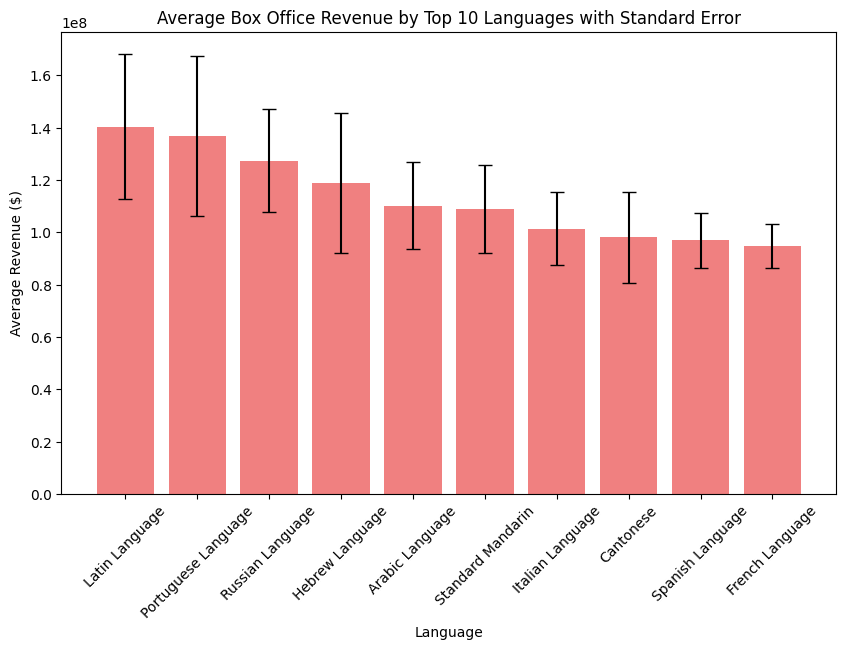

In [13]:
# Calculate average revenue, standard error and count by primary language
language_stats = df_languages.groupby('all_languages')['box_office_revenue'].agg(['mean', 'sem', 'count'])

#We filter out the statistically irrelevant languages
language_stats = language_stats[language_stats['count'] >= 30]

# Select the top 10 languages with the highest average revenue
top_10_languages = language_stats.sort_values(by='mean', ascending=False).head(10)

# Print the average revenue by language
print("Average Box Office Revenue by Top 10 Languages:")
print(top_10_languages)

# Plot the average revenue by language
plt.figure(figsize=(10, 6))
plt.bar(top_10_languages.index, top_10_languages['mean'], yerr=top_10_languages['sem'], color='lightcoral', capsize=5)
plt.title('Average Box Office Revenue by Top 10 Languages with Standard Error')
plt.xlabel('Language')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

# !!!Redo analysis!!!

### Analysis of Average Box Office Revenue by Language

The average box office revenues based on the primary language of the films are as follows:

- **Old English Language**: $747.46 million
- **Greek Language**: $489.29 million
- **Swiss German Language**: $485.93 million
- **Sinhala Language**: $333.11 million
- **Hmong Language**: $269.96 million
- **Sicilian Language**: $268.50 million
- **Picard Language**: $245.14 million
- **Zulu Language**: $242.89 million
- **Gaelic**: $204.04 million
- **Sioux Language**: $184.99 million

#### Observations

1. **Dominance of Old English Films**: Films in Old English yield the highest average revenue, suggesting a robust market for films that leverage historical or cultural themes associated with this language. This may be indicative of both niche audiences and potential global appeal.

2. **Significant Revenue from Greek and Swiss German Films**: The substantial average revenues from Greek and Swiss German films point to the successful commercialization of films in these languages, possibly due to strong cultural narratives or diasporic audiences.

3. **Niche Markets for Lesser-Known Languages**: Languages such as Sinhala and Hmong, while generating lower average revenues, highlight the existence of niche markets. These languages may attract dedicated audiences interested in regional storytelling and representation.

#### Possible Causes

1. **Cultural Resonance**: Films in languages like Old English and Greek may resonate more deeply with audiences who appreciate historical and culturally rich narratives, contributing to higher box office performance.

2. **Diverse Audience Reach**: The presence of significant diasporic communities can drive demand for films in specific languages, as seen with Greek and Swiss German films. These audiences are often eager to engage with content that reflects their heritage.

3. **Engagement with Unique Themes**: Films in lesser-known languages often explore themes that are not typically covered in mainstream cinema, allowing them to carve out a distinct audience. The appeal of unique storytelling may lead to dedicated viewership, even if overall revenues are lower.

4. **Festival Circuit Success**: Many films in niche languages tend to perform well in film festivals, which can enhance their visibility and reputation, potentially boosting their box office revenue over time through word-of-mouth and critical acclaim.

In [240]:
### Which 10 actors have the highest average box office revenue? (actors that participate in more than 20 films)

df_characters_revenues = df_characters.merge(df_movies[['wikipedia_movie_id', 'box_office_revenue']], how='inner')

# keep only actors with at least 50 movies
actors_count = df_characters_revenues['actor_name'].value_counts()
actors = actors_count[actors_count >= 20]

df_characters_revenues = df_characters_revenues[df_characters_revenues['actor_name'].isin(actors.index)]

# calculate the average revenue for each actor
actors_revenues = df_characters_revenues.groupby('actor_name')['box_office_revenue'].mean().sort_values(ascending=False)

print("Top 10 Actors by Average Box Office Revenue:")
print(actors_revenues.head(10))


Top 10 Actors by Average Box Office Revenue:
actor_name
Hugo Weaving            3.706721e+08
Alan Rickman            3.520243e+08
Robbie Coltrane         3.364884e+08
Maggie Smith            3.200121e+08
John Rhys-Davies        3.135264e+08
Richard Griffiths       3.086754e+08
Will Smith              3.083475e+08
Helena Bonham Carter    3.022026e+08
Christopher Lee         2.943084e+08
Timothy Spall           2.930718e+08
Name: box_office_revenue, dtype: float64


Average Box Office Revenue by Actors Age:
actor_age_group
adult          9.748053e+07
child          8.424753e+07
senior         1.008364e+08
teen           6.247093e+07
young_adult    7.274282e+07
Name: mean, dtype: float64


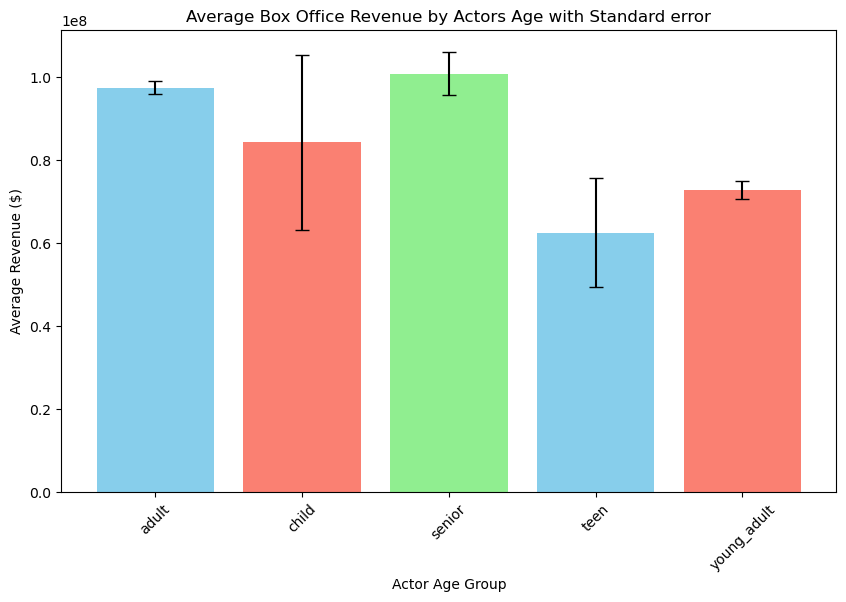

In [241]:
# Average Box Office Revenue by Actors Age Group
df_characters_revenues['actor_age_group'] = df_characters_revenues['actor_age'].apply(data_utils.categorize_age_group)

# Calculate average revenues and standard error for each season
age_stats = df_characters_revenues.groupby('actor_age_group')['box_office_revenue'].agg(['mean', 'count', 'sem'])

# Print the average revenues by season
print("Average Box Office Revenue by Actors Age:")
print(age_stats['mean'])

# Plot the average revenues with standard error bars
plt.figure(figsize=(10, 6))
plt.bar(age_stats.index, age_stats['mean'], yerr=age_stats['sem'], color=['skyblue', 'salmon', 'lightgreen'], capsize=5)
plt.title('Average Box Office Revenue by Actors Age with Standard error')
plt.xlabel('Actor Age Group')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()


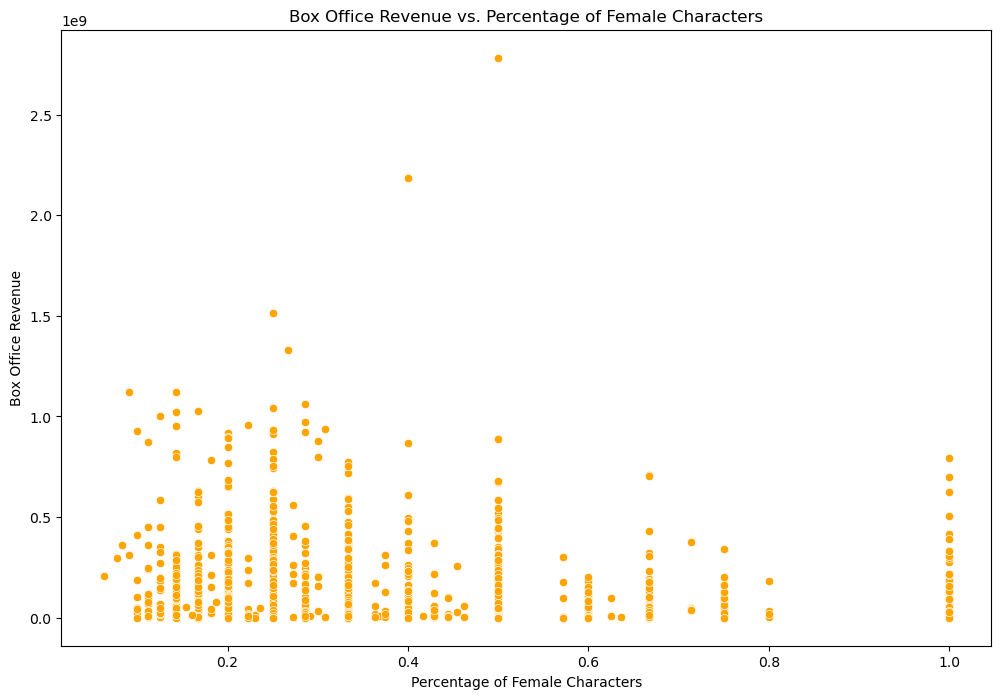

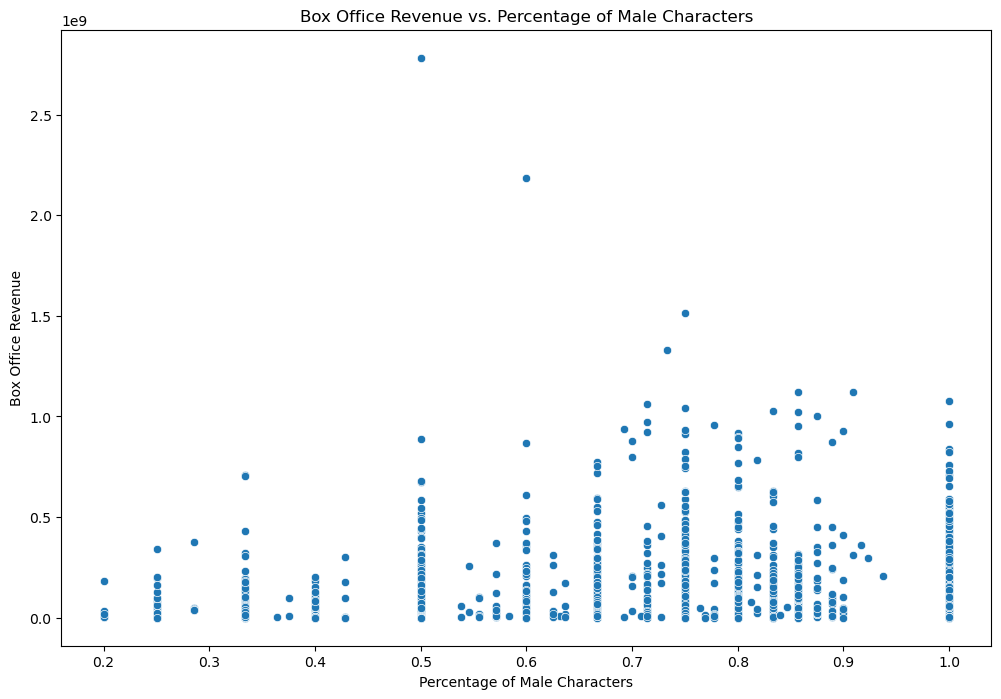

Average Box Office Revenue by Actors Gender Dominance:
dominant_gender
Balanced    5.638539e+07
Female      4.382995e+07
Male        6.825492e+07
Name: mean, dtype: float64


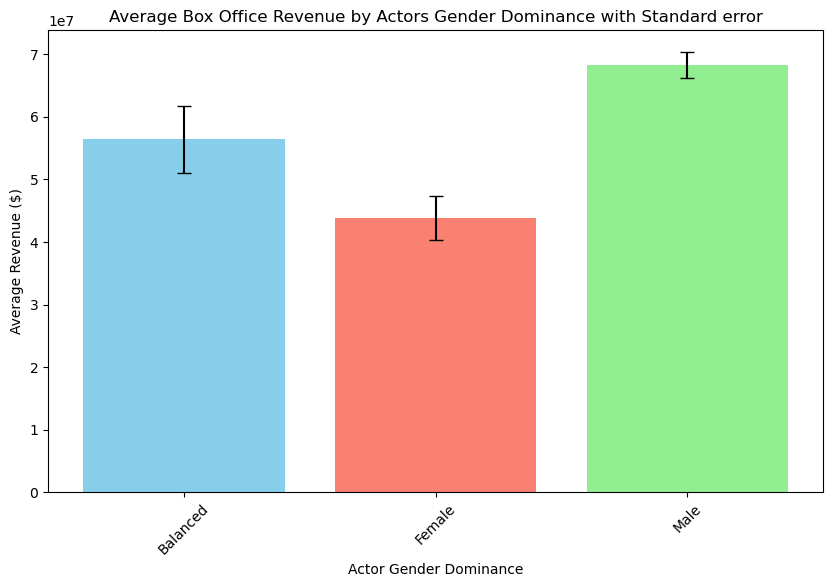

In [242]:
# Box office revenue based on the gender of the actors? 
movies_dominant_gender = df_characters_revenues.groupby(['wikipedia_movie_id', 'box_office_revenue'])['actor_gender'].value_counts(normalize=True).unstack().reset_index()
movies_dominant_gender = movies_dominant_gender.rename(columns={'F': 'Female', 'M': 'Male'})
movies_dominant_gender['dominant_gender'] = movies_dominant_gender.apply(
    lambda row: 'Balanced' if row['Male'] == row['Female'] else row[['Male', 'Female']].idxmax(), axis=1
)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=movies_dominant_gender, x='Female', y='box_office_revenue', color='orange')
plt.xlabel('Percentage of Female Characters')
plt.ylabel('Box Office Revenue')
plt.title('Box Office Revenue vs. Percentage of Female Characters')
plt.show()

plt.figure(figsize=(12, 8))
sns.scatterplot(data=movies_dominant_gender, x='Male', y='box_office_revenue')
plt.xlabel('Percentage of Male Characters')
plt.ylabel('Box Office Revenue')
plt.title('Box Office Revenue vs. Percentage of Male Characters')
plt.show()

gender_stats = movies_dominant_gender.groupby('dominant_gender')['box_office_revenue'].agg(['mean', 'count', 'sem'])

# Print the average revenues by season
print("Average Box Office Revenue by Actors Gender Dominance:")
print(gender_stats['mean'])

# Plot the average revenues with standard error bars
plt.figure(figsize=(10, 6))
plt.bar(gender_stats.index, gender_stats['mean'], yerr=gender_stats['sem'], color=['skyblue', 'salmon', 'lightgreen'], capsize=5)
plt.title('Average Box Office Revenue by Actors Gender Dominance with Standard error')
plt.xlabel('Actor Gender Dominance')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Ethnicity

## Part 3 : Investigation of features' possible correlation

## Part 4 : Create a predictive model for box office success

## Results & conclusion

## 